# Elastix

This notebooks show very basic image registration examples with on-the-fly generated binary images.

In [1]:
from itk import itkElastixRegistrationMethodPython
from itk import itkTransformixFilterPython
import itk
import numpy as np
import matplotlib.pyplot as plt

## Image generators

In [2]:
def image_generator(x1, x2, y1, y2, upsampled=False, bspline=False,
                   mask=False, artefact=False):
    if upsampled:
        image = np.zeros([1000, 1000], np.float32)
    elif mask:
        image = np.zeros([100, 100], np.uint8)
    else:
        image = np.zeros([100, 100], np.float32)
    for x in range(x1, x2):
        for y in range(y1, y2):
            if bspline:
                y += x
                if x > 99 or y > 99:
                    pass
                else:
                    image[x, y] = 1
            else:
                image[x, y] = 1
    if artefact:
        image[:, -10:] = 1
    image = itk.image_view_from_array(image)
    return image

## Point set transformation test
See example 10 for more explanation

In [3]:
def point_set_from_txt(file_path):
    image = np.zeros([100, 100], np.float32)
    with open(file_path, "rt") as myfile: # Open lorem.txt for reading text data.
        for myline in myfile:                # For each line, stored as myline,
            string = myline.partition('OutputIndexMoving =')[2]
            string=string.strip()
            string = string.strip('[]')
            string=string.strip()
            y,x = string.split()
            image[int(x),int(y)] = 1
    return image

def point_set_from_input(x,y):
    image = np.zeros([100, 100], np.float32)
    for i in range(len(x)):
        image[x[i],y[i]]=1
    return image

In [4]:
# Create rigid transformed test images with artefact
fixed_image = image_generator(25, 76, 25, 76)
moving_image = image_generator(1, 52, 10, 61)

# Create fixed point set
fixed_point_set = open("data/fixed_point_set_test.txt", "w+")
fixed_point_set.write("point\n5\n")
fixed_point_set.write("25 25\n")
fixed_point_set.write("25 75\n")
fixed_point_set.write("75 75\n")
fixed_point_set.write("75 25\n")
fixed_point_set.write("50 50")
fixed_point_set.close()


# Import Default Parameter Map
parameter_object = itk.ParameterObject.New()
default_rigid_parameter_map = parameter_object.GetDefaultParameterMap('rigid')
parameter_object.AddParameterMap(default_rigid_parameter_map)

# # Call registration function
result_image, result_transform_parameters = itk.elastix_registration_method(
    fixed_image, moving_image,
    parameter_object=parameter_object)

# Call transformix
empty_image = itk.transformix_filter(
    moving_image=moving_image,
    fixed_point_set_file_name='data/fixed_point_set_test.txt',
    transform_parameter_object=result_transform_parameters,
    output_directory='exampleoutput')

result_point_set = point_set_from_txt('exampleoutput/outputpoints.txt')
fixed_point_set = point_set_from_input([25,25,75,75,50],[25,75,75,25,50])

### Point set transformation test Visualization

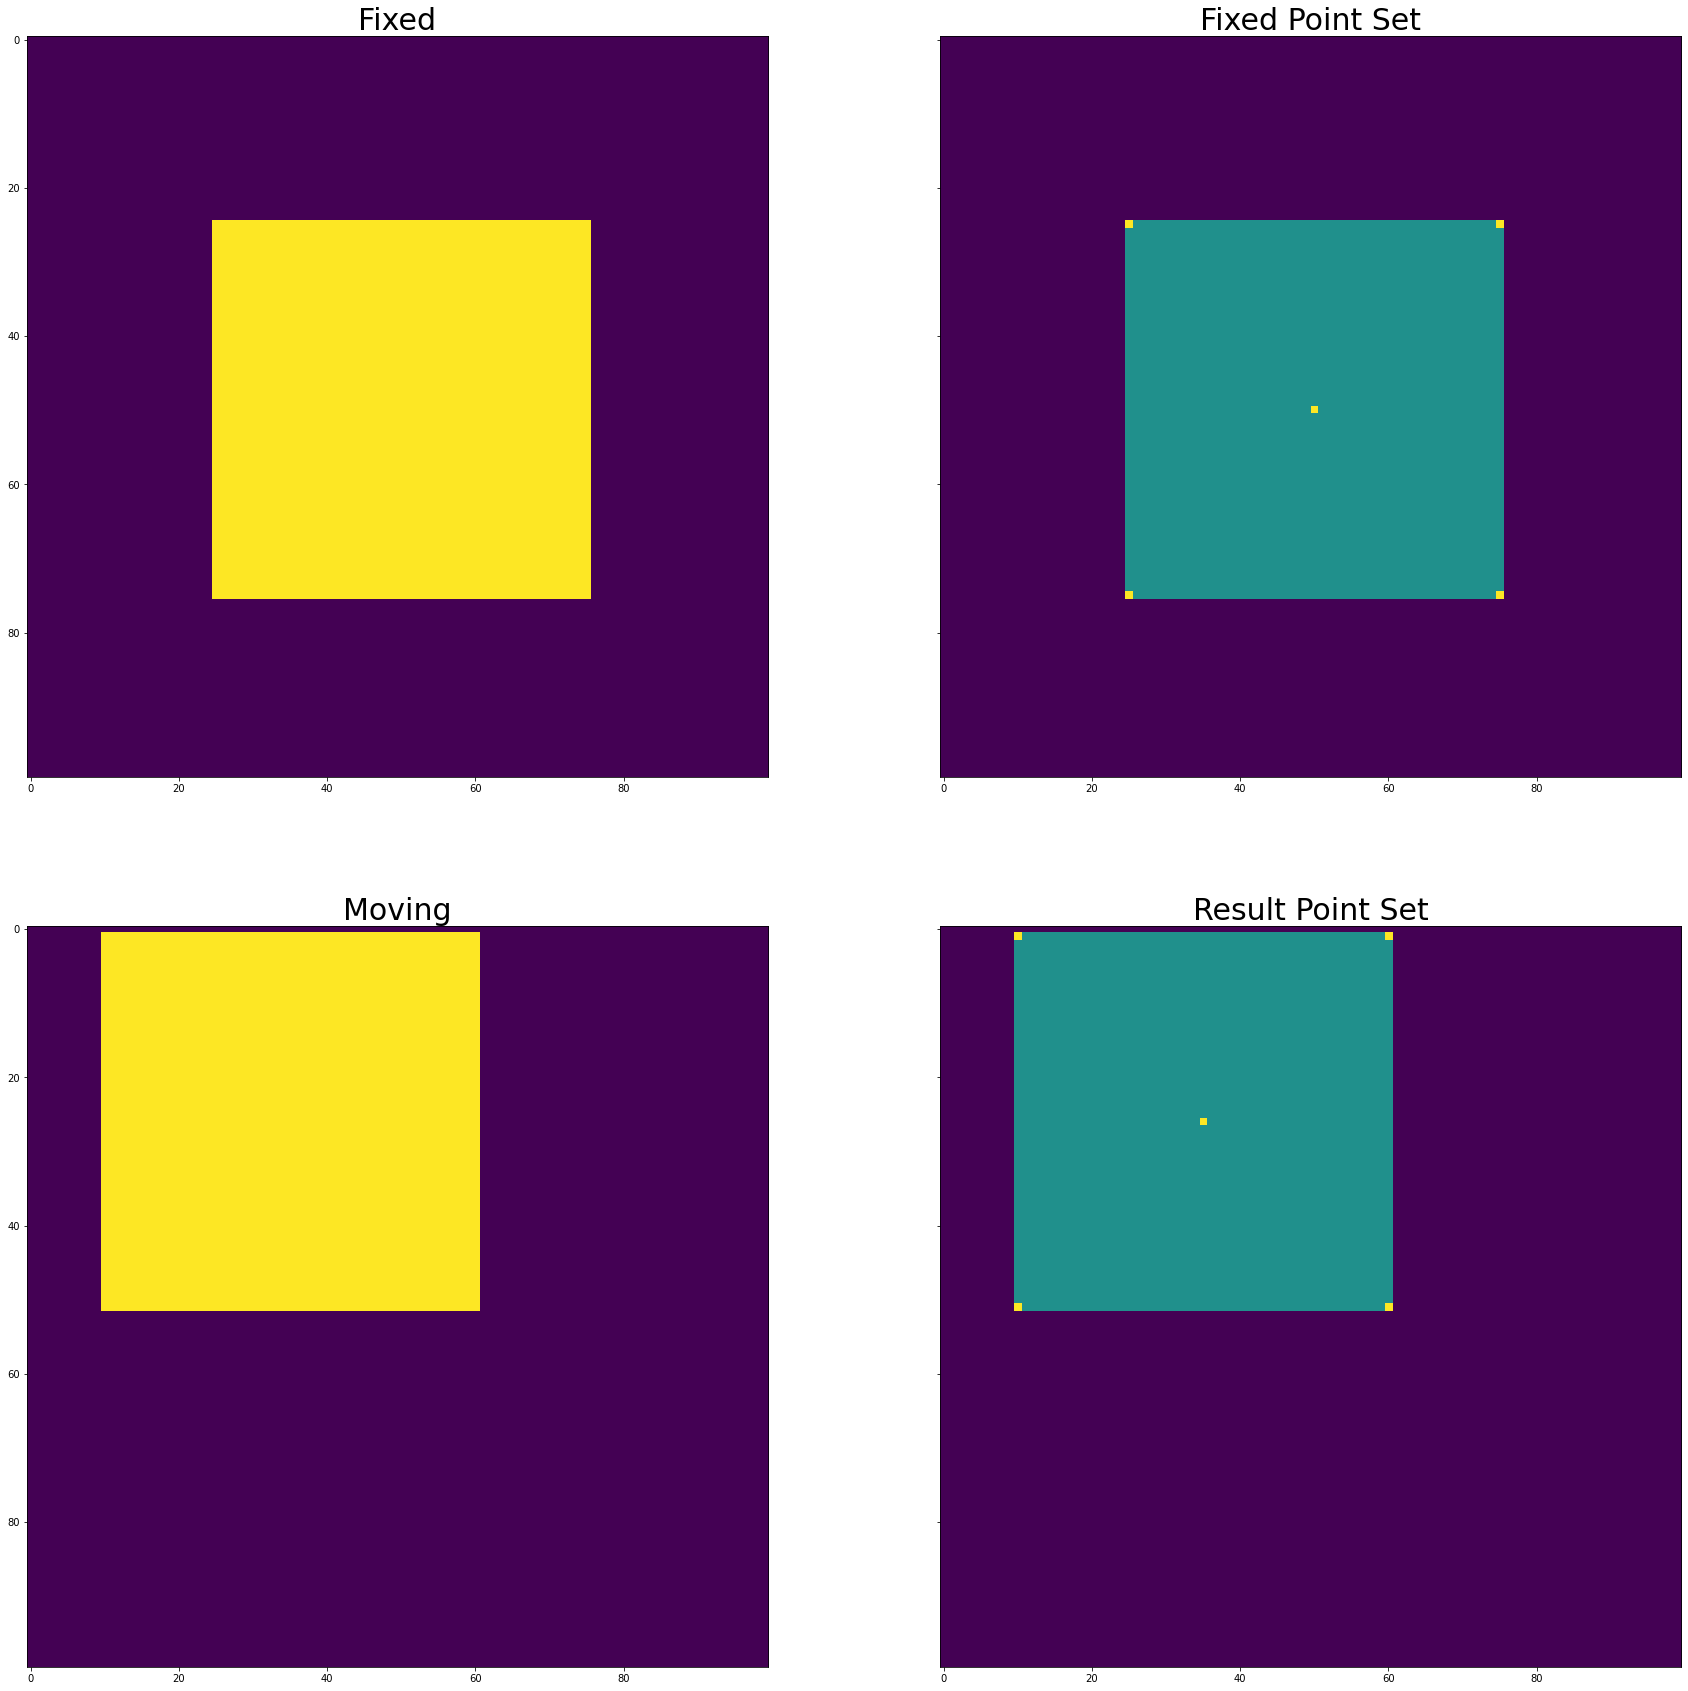

In [5]:
%matplotlib inline

# Plot images
fig, axs = plt.subplots(2,2, sharey=True, figsize=[30,30])
plt.figsize=[100,100]
axs[0,0].imshow(fixed_image)
axs[0,0].set_title('Fixed', fontsize=30)
axs[0,1].imshow(fixed_point_set+fixed_image)
axs[0,1].set_title('Fixed Point Set', fontsize=30)
axs[1,0].imshow(moving_image)
axs[1,0].set_title('Moving', fontsize=30)
axs[1,1].imshow(result_point_set+moving_image)
axs[1,1].set_title('Result Point Set', fontsize=30)
plt.show()